## Suppl. Fig. 8 panel B Clustering score (external datasets)

[NOTE]: before running this notebook, please run the following two notebooks:  
- `Suppl_fig8/panel_A/Suppl_fig8_A_external_UMAPs.ipynb`
- `Suppl_fig8/panel_B/process_internal_variant/OrgIP/UMAP/OrgIP_umap.ipynb`  

This notebook scores UMAPs using two sets of ground truth: corum complexes and organelle residient proteins.  
For each dataset, scores are computed for each UMAP (bootstrap). The mean score and SEM of estimating the mean are plotted.
The parameters are set to be "optimal" values and close to what we likely use for the final plot.  
Please note that changing the parameters may cause the run to halt at the check-parameter cell, this is to notify that a non-optimal parameter is selected. you can simply skip that cell to continue  

In [1]:
import os, sys, re, statistics
from pathlib import Path
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns

script_path = Path.cwd().parent.parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent.parent / "data"
sys.path.append(str(script_path))

from external import clustering_workflows
plt.rcParams['pdf.fonttype'] = 42

outdir = Path.cwd() / "output" 
outdir.mkdir(exist_ok=True)

### parameters

In [2]:
score_algo = "calinski_harabasz" # possible values: "calinski_harabasz", "silhouette" or "davies_bouldin" 

# global parameters
use_full_dataset = False                  # True = use full dataset, False = use intersect
verbose = False

# parameterization for ground truth
# corum
use_corum = True                          # True = use corum complex, False = use OpenCell complex
min_complex_labels = 5                    # filter out complex if it has less than this number of labels in the scoring set
# organelle
rm_nuc_pore = True                        # True = remove nuclear pore complexes, False = keep nuclear pore complexes
membrane_bound_organelle_only = False     # True = only use membrane-bound organelles, False = use all organelles
membraneless_only = False                  # True = only use membraneless organelles, False = use all organelles
membrane_bound_organelles = ['mitochondria', 'early_endosome', 'ER' , 'plasma membrane', 'peroxisome', 'lysosome', 'ERGIC', 'Golgi'] # only used if membrane_bound_organelle_only is True, not including nucleus
membraneless_organelles = ['centrosome', 'cytosol', 'nucleus', 'p-body', 'stress granule'] # only used if membraneless_only is True, not including actin-binding_protein and ribosome
# organelle class balancing (only active for calinski_harabasz)
balance_org_ground_truth = True           # only active if set to True and selected calinski_harabasz scoring algorithm
min_class_size_multiplier = 1             # minimum size of class as a fraction of the largest class size
difference_multiplier = 0                 # minimum difference between class sizes as a fraction of the largest class size
nbootstrap = 200


### datasets

In [3]:
dataset_dirs = ["OrgIP", "DIA-DOMs-2023", "BioID2021-NMF", "hyperLOPITU2OS2018",
                  "LOPITDCU2OS2018", "itzhak2016stcSILAC", "itzhak2016stcSILAC-NOC"]

# dataset names to show in the plot
# this is a mapping from Duo's version of the dataset name to the name that should be shown in the plot
dataset_name_mapping = {
    "OrgIP": "this study", 
     "HEK_centrifugation": "HEK293 centrifugation", 
     "DIA-DOMs-2023": "Schessner et al. 2023 (step ultracentrifugation, DIA)",
     "hyperLOPITU2OS2018": "Geladaki et al. 2019 (HYPERLOPIT ultracentrifugation)",
     "LOPITDCU2OS2018": "Geladaki et al. 2019 (LOPIT-DC ultracentrifugation)",
     "itzhak2016stcSILAC": "Itzhak et al. 2016 (step ultracentrifugation, DDA)",
     "itzhak2016stcSILAC-NOC": "Itzhak et al. 2016 (step ultracentrifugation, DDA) N/O/C fractions included",
     "DLOPIT2024":"Villanueva et al. 2024 (density-based LOPIT)",
     "BioID2021-NMF":"Go et al. 2021 (bioID proximity ligation, NMF)",
     "BioID2021-NMF-tSNE":"Go et al. 2021 (bioID proximity ligation, NMF) tSNE",
}

### check parameters
this section will halt the run if the parameters are not optimal/default (for example, if using membrane-only ground truth for scoring)  
you can by-pass this cell and "Run All Below"

In [4]:
class NonOptimumParameterError(ValueError):
    pass

if use_full_dataset:
    raise NonOptimumParameterError("non optimum/default parameter: using full dataset")
if not use_corum:
    raise NonOptimumParameterError("non optimum/default parameter: not using corum complex")
if min_complex_labels == 0:
    raise NonOptimumParameterError("non optimum/default parameter: no filter for min_complex_labels")
if not rm_nuc_pore:
    raise NonOptimumParameterError("non optimum/default parameter: not removing nuclear pore complexes")
if not balance_org_ground_truth:
    raise NonOptimumParameterError("non optimum/default parameter: not balancing organelle classes")
if nbootstrap == 0:
    raise NonOptimumParameterError("non optimum/default parameter: not bootstrapping the score computation")
if score_algo == "duo" and not exhaustive_inter_pairs:
    raise NonOptimumParameterError("non optimum/default parameter: using duo score with sampling inter pairs")
if score_algo == "duo" and mean:
    raise NonOptimumParameterError("non optimum/default parameter: using duo score with mean")
if membrane_bound_organelle_only and membraneless_only:
    raise ValueError("both membrane_bound_organelle_only and membraneless_only are True")
if membrane_bound_organelle_only:
    raise NonOptimumParameterError("non optimum/default parameter: only using membrane-bound organelles")
if membraneless_only:
    raise NonOptimumParameterError("non optimum/default parameter: only using membraneless organelles")

### helper functions

In [5]:
# helper function
def translate_and_count(row, translation_dict):
    # Split the semicolon-separated values
    values = row.split(';')
    translated_values = []

    for value in values:
        # Attempt to translate the value directly
        translation = translation_dict.get(value)
        if translation is None:
            # If direct translation fails, try removing contents after a hyphen and translate again
            value_base = value.split('-')[0]
            translation = translation_dict.get(value_base, value_base)
        translated_values.append(translation)

    # Count the translations
    translation_counts = Counter(translated_values)
    # Find the highest count
    max_count = max(translation_counts.values())
    # Find all translations with the highest count
    most_common_translations = [k for k, v in translation_counts.items() if v == max_count]
    # Choose the shortest translation in case of ties
    most_common_translation = min(most_common_translations, key=len)
    
    return most_common_translation

def calinski_harabasz_score_wrapper(df, gt, k, n_bootstraps=nbootstrap, verbose=False, mean=False):
    ''' balance the ground truth data, and bootstrap the calinski_harabasz_score
        input: a df in datasets
        gt: ground truth data
        n_bootstraps: number of bootstraps
        verbose: print the progress
        mean: True = mean, False = median
    '''
    import warnings
    # Suppress the specific DeprecationWarning
    warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*DataFrameGroupBy.apply operated on the grouping columns.*")

    gt_scores = []
    for i in range(n_bootstraps):
        # balance the ground truth data
        groups = gt.groupby('compartment')
        # Determine the size of the smallest group
        min_size = min(groups.size())
        # Calculate the threshold for undersampling (10% more than the minimum size)
        threshold_size = min_size * min_class_size_multiplier
        # Perform conditional undersampling
        def undersample_or_not(group):
            if len(group) > threshold_size:
                return group.sample(int(threshold_size + (len(group) - min_size)*difference_multiplier))
            else:
                return group
        balanced_gt = groups.apply(undersample_or_not).reset_index(drop=True)

        # compute ground truth score
        merged = df.merge(balanced_gt, left_on = "Gene_name_for_scoring", right_on = "gene_name_canonical", how = "left").drop_duplicates()
        merged = merged.dropna(subset=['compartment'])
        map_data = merged[['umap_1', 'umap_2']].to_numpy()
        # convert organelle names to integers
        unique_strings = list(set(merged['compartment'])) 
        str_to_int_mapping = {string: index for index, string in enumerate(unique_strings)} # Create a mapping from strings to unique integers
        
        org_label_data = [str_to_int_mapping[s] if not pd.isna(s) else s for s in merged['compartment']] # Convert the list of strings to a list of integers
        org_label_data = np.array(org_label_data)

        if score_algo == "calinski_harabasz":
            gt_score = calinski_harabasz_score(map_data, org_label_data)
        else:
            raise ValueError(f"score_algo {score_algo} is not implemented in calinski_harabasz_score_wrapper")
        gt_scores.append(gt_score)
    if mean:
        return statistics.mean(gt_scores)
    else:
        return statistics.median(gt_scores)

### load datasets

In [6]:
datasets = defaultdict(list) # store datasets in a dictionary, key is the dataset name, value is a list of dataframes

for d in dataset_dirs:
    p_ext = Path().cwd().parent / "panel_A" / "output" / d # read external UMAPs from the central location for external umaps (note that the external_datasets folder has dispersed UMAPs, and we have retired them)
    p_int = Path().cwd() /  "process_internal_variant" / d # read internal UMAPs from the internal_dataset folder (the only copy of internal UMAPs)
    if os.path.exists(p_ext):
        p = p_ext
        p1 = p / "UMAP" / "bootstraps"
    elif os.path.exists(p_int):
        p = p_int
        p1 = p / "UMAP" / "output" / "bootstraps"
    else:
        raise ValueError(f"can't find {d} in {p_ext} or {p_int}")

    if os.path.exists(p1):
        for f in p1.iterdir():
            dat_path = p1 / f
            if dat_path.is_file() and f.suffix == ".csv":
                datasets[d].append(pd.read_csv(f))
    else:
        print(f"failed to open {p1} for {d}")

In [7]:
# load ground truth data and open cell data
gt9 = pd.read_csv(os.path.join(data_path, "external" , "curated_ground_truth_v9.0.csv"))[[
    "gene_name_canonical","compartment"]].copy()
oc_comp = pd.read_csv(os.path.join(data_path, "external" , "OpenCell_core_clusters_list.csv"))[[
    'protein','core_complex_id']].copy()

# remove nuclear pore from ground truth data
if rm_nuc_pore:
    gt9 = gt9[gt9.compartment != "nuclear_pore"]
    print(gt9.compartment.unique())
# remove non-membrane-bound organelles from ground truth data
if membrane_bound_organelle_only:
    gt9 = gt9[gt9.compartment.isin(membrane_bound_organelles)]
    print(gt9.compartment.unique())
if membraneless_only:
    gt9 = gt9[gt9.compartment.isin(membraneless_organelles)]
    print(gt9.compartment.unique())

['actin-binding_protein' 'centrosome' 'cytosol' 'early_endosome' 'ER'
 'ERGIC' 'Golgi' 'lysosome' 'mitochondria' 'nucleus' 'p-body' 'peroxisome'
 'plasma membrane' 'ribosome' 'stress granule']


In [8]:
corum = pd.read_csv(os.path.join(data_path, "external" , "Corum.4.0.tsv"), sep='\t')
corum_gens = []
corum_complexids = []

for idx, row in corum.iterrows():
    names = row['subunits(Gene name)'].split(';')
    try:
        syns = re.split(r'[; ]+', row['subunits(Gene name syn)'])
    except:
        syns = []
    for name in names:
        corum_gens.append(name)
        corum_complexids.append(row['ComplexID'])
    for syn in syns:
        corum_gens.append(syn)
        corum_complexids.append(row['ComplexID'])

corum4 = pd.DataFrame({'gene_name': corum_gens, 'complex_id': corum_complexids})

### find common sets of genes shared by all datasets

In [9]:
# load prot_ID to gene name mapping
df = pd.read_csv(data_path / "external" / "HUMAN_9606_idmapping.dat", sep="\t", header=None)
prot2gene = dict(zip(df[0], df[2]))


In [10]:
# convert protein IDs to gene names
curated_gene_names = defaultdict()

for k in datasets.keys():
    df = datasets[k][0] # take the first bootstrap UMAP dataframe
    
    if k.startswith("OrgIP") and "Gene_name_canonical" in df.columns: 
        # for OrgIp use the `Gene_name_cannoical` column
        curated_gene_names[k] = df["Gene_name_canonical"]
        print(f"Using Gene_name_cannoical for {k}, total {len(curated_gene_names[k])} genes")

    elif k.startswith("BioID2021-NMF"):
        curated_gene_names[k] = df["Gene names remapped"]
        print(f"using gene column for {k}, total {len(curated_gene_names[k])} genes")
    else:
        curated_gene_names[k] = df["Protein IDs"].apply(translate_and_count, translation_dict=prot2gene)
        print(f"mapping Protein IDs for {k}, total {len(curated_gene_names[k])} genes")
    

Using Gene_name_cannoical for OrgIP, total 8541 genes
mapping Protein IDs for DIA-DOMs-2023, total 7443 genes
using gene column for BioID2021-NMF, total 4424 genes
mapping Protein IDs for hyperLOPITU2OS2018, total 4883 genes
mapping Protein IDs for LOPITDCU2OS2018, total 6837 genes
mapping Protein IDs for itzhak2016stcSILAC, total 4928 genes
mapping Protein IDs for itzhak2016stcSILAC-NOC, total 4928 genes


In [11]:
# find the overlap between the datasets
def find_intersection(lists):
    if not lists:
        return []
    # Convert the first list to a set
    intersection_set = set(lists[0])
    # Intersect with all subsequent sets
    for lst in lists[1:]:
        intersection_set.intersection_update(lst)
    return list(intersection_set)

# find the intersection of the gene names
if use_full_dataset:
    print("using full datase, and skipping finding intersection")
else:
    intersection_byall = find_intersection([set(genes) for genes in curated_gene_names.values()])
    print(f"between datasets: {', '.join(curated_gene_names.keys())}\nthe total number of shared of genes are: {len(intersection_byall)}\n")

# save the intersection list to file
if not use_full_dataset:
    with open(outdir / "intersection_genes.txt", "w") as f:
        for gene in intersection_byall:
            f.write(f"{gene}\n")

between datasets: OrgIP, DIA-DOMs-2023, BioID2021-NMF, hyperLOPITU2OS2018, LOPITDCU2OS2018, itzhak2016stcSILAC, itzhak2016stcSILAC-NOC
the total number of shared of genes are: 2109



### compute clustering scores for each dataset

In [12]:
# check the ground truth class counts
#gt9["compartment"].value_counts()

In [13]:
# setup class-balance utility for the ground truth data
groups = gt9.groupby('compartment')
# Determine the size of the smallest group
min_size = min(groups.size())
# Calculate the threshold for undersampling (10% more than the minimum size)
threshold_size = min_size * min_class_size_multiplier
# Perform conditional undersampling
def undersample_or_not(group):
    if len(group) > threshold_size:
        return group.sample(int(threshold_size + (len(group) - min_size)*difference_multiplier))
    else:
        return group


In [14]:
# go through each umap and compute scores
gt_scores = defaultdict(list)
complex_scores = defaultdict(list)

for k in datasets.keys():
    print(f"Computing scores for {k}",flush=True)
    # retrieve the pre-mapped gene names
    gene_names = curated_gene_names[k]
    for i, df in tqdm(enumerate(datasets[k]), total = len(datasets[k]), desc = "Bootstraps"):
        df["Gene_name_for_scoring"] = gene_names

        # subset the dataframes to only include the shared genes for a fair comparison
        if use_full_dataset:
            print(f"....number of proteins: {df.shape[0]}", flush=True) if i == 0 else None
        else:
            df = df[df["Gene_name_for_scoring"].isin(intersection_byall)]
            print(f"....number of proteins after intersect: {df.shape[0]}", flush=True) if i == 0 else None

        if 'core_complex_id' in df.columns:
            df = df.drop(columns=['core_complex_id'])

        #########################
        # compute complex score #
        #########################
        if use_corum:
            merged = df.merge(corum4, left_on = "Gene_name_for_scoring", right_on = "gene_name", how = "left").drop_duplicates()
            complexdb_name = "Corum"
        else:
            merged = df.merge(oc_comp, left_on = "Gene_name_for_scoring", right_on = "protein", how = "left").drop_duplicates()
            merged.rename(columns={"core_complex_id": "complex_id"}, inplace=True)
            complexdb_name = "OpenCell"
        print(f"....number of complex annotations: {merged[~merged['complex_id'].isna()].shape[0]}", flush=True) if i == 0 else None
        # remove complexes with less than min_complex_labels
        print(f"....number of unique complexes: {merged['complex_id'].nunique()}", flush=True) if i == 0 else None
        if min_complex_labels:
            complex_counts = merged['complex_id'].value_counts()
            complex_ids = complex_counts[complex_counts >= min_complex_labels].index
            merged = merged[merged['complex_id'].isin(complex_ids)]
        print(f"....number of unique complexes after filtering: {merged['complex_id'].nunique()}", flush=True) if i == 0 else None

        merged = merged.dropna(subset=['complex_id'])
        map_data = merged[['umap_1', 'umap_2']].to_numpy()
            
        if score_algo == "silhouette":
            complex_score = silhouette_score(map_data, merged['complex_id'].to_numpy())
        elif score_algo == "davies_bouldin":
            complex_score = davies_bouldin_score(map_data, merged['complex_id'].to_numpy())
        elif score_algo == "calinski_harabasz":
            complex_score = calinski_harabasz_score(map_data, merged['complex_id'].to_numpy())
        test_data = map_data # save a copy for testing
        test_label = merged['complex_id'].to_numpy() # save a copy for testing
        
        # print the number of proteasome in corum data
        corum_slice = corum[corum["ComplexID"].isin(merged['complex_id'].unique())]
        corum_slice_proteasome = corum_slice[corum_slice["GO description"].str.contains("proteasom", case=False, na=False)]
        print(f"....number of proteasome-related corum complexes in corum data: {corum_slice_proteasome.shape[0]}", flush=True) if i == 0 else None

        #############################################################
        # compute ground truth score aka. compartment/organelle score#
        #############################################################
        merged = df.merge(gt9, left_on = "Gene_name_for_scoring", right_on = "gene_name_canonical", how = "left").drop_duplicates()
        print(f"....number of ground truth annotations: {merged[~merged['compartment'].isna()].shape[0]}", flush=True) if i == 0 else None

        merged = merged.dropna(subset=['compartment'])
        map_data = merged[['umap_1', 'umap_2']].to_numpy()

        # convert organelle names to integers
        unique_strings = list(set(merged['compartment'])) 
        str_to_int_mapping = {string: index for index, string in enumerate(unique_strings)} # Create a mapping from strings to unique integers
        int_to_str_mapping = {index: string for index, string in enumerate(unique_strings)} # Create a mapping from unique integers to strings
        org_label_data = [str_to_int_mapping[s] if not pd.isna(s) else s for s in merged['compartment']] # Convert the list of strings to a list of integers
        org_label_data = np.array(org_label_data)
        if score_algo == "duo":
            res = clustering_workflows.average_intra_label_to_overall_distance(map_data,org_label_data, mean = mean, sample_size=sample_size, verbose=verbose, exhaustive_inter_pairs = exhaustive_inter_pairs, return_intra_distances = True)
            gt_score = res[0]
        elif score_algo == "silhouette":
            gt_score = silhouette_score(map_data, org_label_data)
        elif score_algo == "davies_bouldin":
            gt_score = davies_bouldin_score(map_data, org_label_data)
        elif score_algo == "calinski_harabasz":
            if balance_org_ground_truth:
                # balance the ground truth data, and bootstrap the calinski_harabasz_score
                gt_score = calinski_harabasz_score_wrapper(df, gt9, k, n_bootstraps=nbootstrap, mean=False)
            else:
                gt_score = calinski_harabasz_score(map_data, org_label_data)
        # save scores
        complex_scores[k].append(complex_score)
        gt_scores[k].append(gt_score)

    print("\n\n", flush=True)

Computing scores for OrgIP


Bootstraps:   0%|          | 0/10 [00:00<?, ?it/s]

....number of proteins after intersect: 2261
....number of complex annotations: 4572
....number of unique complexes: 1861
....number of unique complexes after filtering: 166
....number of proteasome-related corum complexes in corum data: 3
....number of ground truth annotations: 709



Computing scores for DIA-DOMs-2023


Bootstraps:   0%|          | 0/10 [00:00<?, ?it/s]

....number of proteins after intersect: 2139
....number of complex annotations: 4348
....number of unique complexes: 1861
....number of unique complexes after filtering: 147
....number of proteasome-related corum complexes in corum data: 3
....number of ground truth annotations: 661



Computing scores for BioID2021-NMF


Bootstraps:   0%|          | 0/10 [00:00<?, ?it/s]

....number of proteins after intersect: 2109
....number of complex annotations: 4321
....number of unique complexes: 1861
....number of unique complexes after filtering: 143
....number of proteasome-related corum complexes in corum data: 3
....number of ground truth annotations: 652



Computing scores for hyperLOPITU2OS2018


Bootstraps:   0%|          | 0/10 [00:00<?, ?it/s]

....number of proteins after intersect: 2123
....number of complex annotations: 4332
....number of unique complexes: 1861
....number of unique complexes after filtering: 144
....number of proteasome-related corum complexes in corum data: 3
....number of ground truth annotations: 657



Computing scores for LOPITDCU2OS2018


Bootstraps:   0%|          | 0/10 [00:00<?, ?it/s]

....number of proteins after intersect: 2148
....number of complex annotations: 4368
....number of unique complexes: 1861
....number of unique complexes after filtering: 143
....number of proteasome-related corum complexes in corum data: 3
....number of ground truth annotations: 665



Computing scores for itzhak2016stcSILAC


Bootstraps:   0%|          | 0/10 [00:00<?, ?it/s]

....number of proteins after intersect: 2132
....number of complex annotations: 4375
....number of unique complexes: 1861
....number of unique complexes after filtering: 151
....number of proteasome-related corum complexes in corum data: 3
....number of ground truth annotations: 662



Computing scores for itzhak2016stcSILAC-NOC


Bootstraps:   0%|          | 0/10 [00:00<?, ?it/s]

....number of proteins after intersect: 2132
....number of complex annotations: 4375
....number of unique complexes: 1861
....number of unique complexes after filtering: 151
....number of proteasome-related corum complexes in corum data: 3
....number of ground truth annotations: 662





### plot the scores

In [15]:
# compute plot data
plot_data = dict()
for k in complex_scores.keys():
    assert k in gt_scores, f"key {k} not found in gt_scores"
    n = len(complex_scores[k])
    x_mean, y_mean = np.mean(gt_scores[k]), np.mean(complex_scores[k])
    x_sem, y_sem =  np.std(gt_scores[k])/np.sqrt(n), np.std(complex_scores[k])/np.sqrt(n)
    x_std, y_std = np.std(gt_scores[k]), np.std(complex_scores[k])

    x_median = np.median(gt_scores[k])
    x_err_upper = np.percentile(gt_scores[k], 90) - x_median
    x_err_lower = x_median - np.percentile(gt_scores[k], 10)
    y_median = np.median(complex_scores[k])
    y_err_upper = np.percentile(complex_scores[k], 90) - y_median
    y_err_lower = y_median - np.percentile(complex_scores[k], 10)

    # map the dataset name to the name that should be shown in the plot
    new_name = dataset_name_mapping.get(k, k)
    plot_data[new_name] = [x_mean, y_mean, x_sem, y_sem, x_std, y_std, x_median, y_median, x_err_upper, x_err_lower, y_err_upper, y_err_lower]
    

In [16]:
# load color palettes
tab10 = [mcolors.to_hex(color) for color in plt.cm.tab10.colors]
set1 = [mcolors.to_hex(color) for color in plt.cm.Set1.colors]
set2 = [mcolors.to_hex(color) for color in plt.cm.Set2.colors]
set3 = [mcolors.to_hex(color) for color in plt.cm.Set3.colors]
paired = [mcolors.to_hex(color) for color in plt.cm.Paired.colors]
dark = [mcolors.to_hex(color) for color in plt.cm.Dark2.colors]

# define color order
colors = [tab10[0]]+ [tab10[4]] + [tab10[6]] + [tab10[8]] + tab10[1:4] + [tab10[5]] + [tab10[7]] + [tab10[9]] + [set2[0]] + [paired[9]] + [dark[5]]

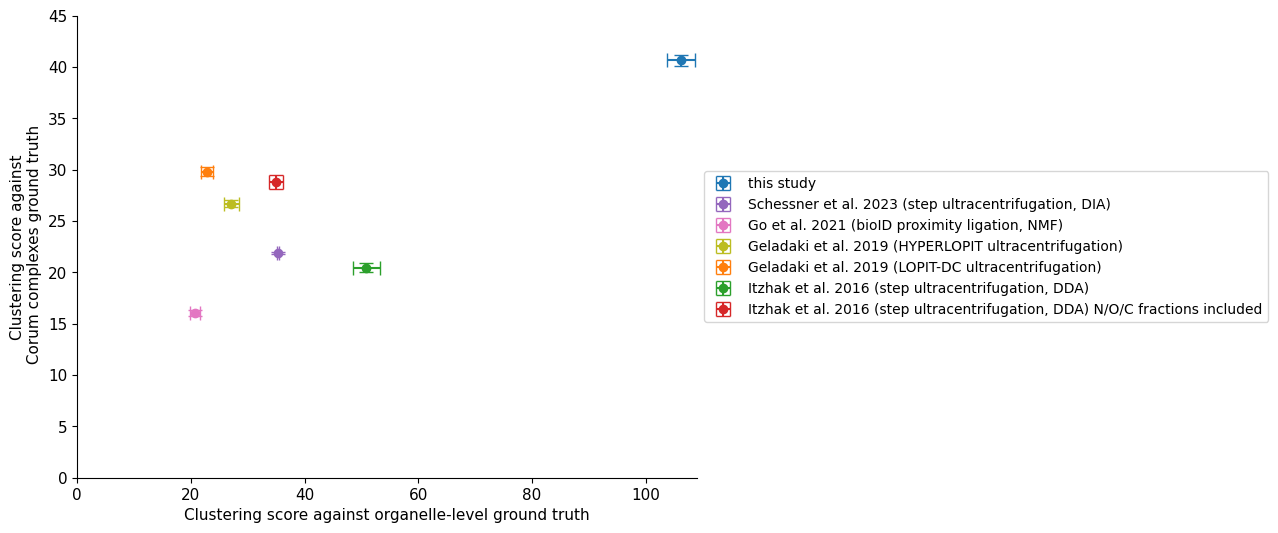

In [17]:
# plot the data
plot_width = 8
plot_height = 6
plot_x_min = 0
plot_x_max = 109
plot_y_min = 0
plot_y_max = 45

plt.figure(figsize=(plot_width, plot_height))
for idx, k in enumerate(plot_data):
    x_mean, y_mean, x_sem, y_sem, x_std, y_std, x_median, y_median, x_err_upper, x_err_lower, y_err_upper, y_err_lower = plot_data[k]
    plt.errorbar(x_mean, y_mean, xerr=x_sem, yerr=y_sem, fmt='o', capsize=5, capthick=1, ecolor=colors[idx], color = colors[idx], label=k)
plt.title('')
plt.xlabel('Clustering score against organelle-level ground truth', fontsize=11)
plt.ylabel(f'Clustering score against\n {complexdb_name} complexes ground truth', fontsize=11)
# check tick label size
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim(plot_x_min, plot_x_max)
plt.ylim(plot_y_min, plot_y_max)
#Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc = 'lower right')
plt.grid(False)
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# save the plot as pdf
plt.savefig(outdir / "clustering_scores_external.pdf", bbox_inches="tight", format="pdf", dpi=600)

plt.show()